https://github.com/kexinhuang12345/DeepPurpose


In [71]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *


In [72]:
# Cell with constants
DATADIR = Path("../data")
RANDOM_SEED = 2407

TMP_DIR = Path("../tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

MODEL_NAME = 'Morgan_AAC_BindingDB'

In [73]:
from prody import parsePDB
structure = parsePDB((DATADIR / 'target.pdb').as_posix(), debug=False)
#[x.name for x in structure.get_atoms() if not x.is_disordered()]
# [x.get_resname() for x in structure.get_residues()]
#structure.getSequence(), structure.getResnums(), [a for a in structure.iterAtoms()]
list(structure.iterChains())
calphas = structure.chain_A_and_calpha
sequence = calphas.getSequence()
sequence

@> 2874 atoms and 1 coordinate set(s) were parsed in 0.11s.
DEBUG:.prody:2874 atoms and 1 coordinate set(s) were parsed in 0.11s.


'EVNSFSGYLKLTDNVYIKNADIVEEAKKVKPTVVVNAANVYLKHGGGVAGALNKATNNAMQVESDDYIATNGPLKVGGSCVLSGHNLAKHCLHVVGPNVNKGEDIQLLKSAYENFNQHEVLLAPLLSAGIFGADPIHSLRVCVDTVRTNVYLAVFDKNLYDKLVSSFLE'

In [115]:
def balance_data(train_df, target_col="Label"):
    df = train_df[target_col].value_counts()
    m = df.max()
    new_index = []
    for i, c in df.reset_index().values:
        ids = train_df[target_col]==i
        values = train_df[ids].index
        if c == m:
            new_index.extend(values)
        else:
            new_index.extend(np.random.choice(values, m))
    return train_df.loc[new_index]

Drug Target Interaction Prediction Mode...
in total: 5557 drug-target pairs
encoding drug...
unique drugs: 5557
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.
Dataset already downloaded in the local system...
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 4.91981. Total time 0.00027 hours
Validation at Epoch 1, AUROC: 0.43080 , AUPRC: 0.03290 , F1: 0.06608 , Cross-entropy Loss: 33.3592
Training at Epoch 2 iteration 0 with loss 0.90398. Total time 0.00361 hours
Validation at Epoch 2, AUROC: 0.47378 , AUPRC: 0.03251 , F1: 0.0 , Cross-entropy Loss: 1.18028
Training at Epoch 3 iteration 0 with loss 0.20962. Total time 0.00722 hours
Validation at Epoch 3, AUROC: 0.51190 , AUPRC: 0.03565 , F1: 0.0 , Cross-entropy Loss: 1.18028
Training at Epoch

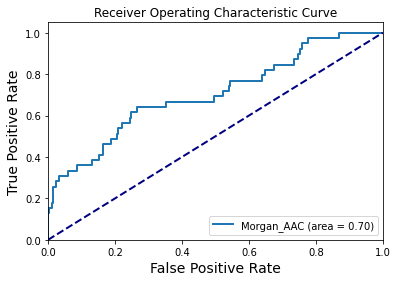

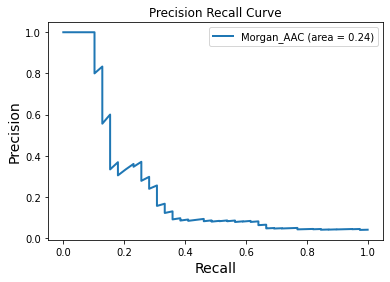

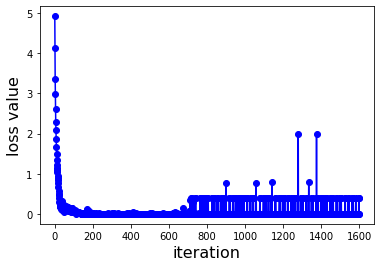

In [87]:

# Load Data, an array of SMILES for drug, an array of Amino Acid Sequence for Target and an array of binding values/0-1 label.
# e.g. ['Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1', ...], ['MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTH...', ...], [0.46, 0.49, ...]
# In this example, BindingDB with Kd binding score is used.
# X_drug, X_target, y  = process_BindingDB(download_BindingDB(SAVE_PATH),
# 					 y = 'Kd', 
# 					 binary = False, 
# 					 convert_to_log = True)

X_drug = list(train_df.Smiles.values)
X_target = [sequence] *train_df.shape[0]
y = train_df.Active.values*1
# Type in the encoding names for drug/protein.
drug_encoding, target_encoding = 'Morgan', 'AAC'

# Data processing, here we select cold protein split setup.
train, val, test = data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='random', 
                                frac=[0.7,0.1,0.2])
train_balanced = balance_data(train)

# Generate new model using default parameters; also allow model tuning via input parameters.
# config = generate_config(drug_encoding, target_encoding, transformer_n_layer_target = 8)
# net = models.model_initialize(**config)

# or simply load pretrained model from a model directory path or reproduced model name such as DeepDTA
net = models.model_pretrained(model=MODEL_NAME, path_dir=TMP_DIR, )

# Train the new model.
# Detailed output including a tidy table storing validation loss, metrics, AUC curves figures and etc. are stored in the ./result folder.
net.train(train_balanceds, val, test)
#save_path=(TMP_DIR / "deep_purpose_save").as_posix(), verbose=True)


# Repurpose using the trained model or pre-trained model
# In this example, loading repurposing dataset using Broad Repurposing Hub and SARS-CoV 3CL Protease Target.
#X_repurpose, drug_name, drug_cid = load_broad_repurposing_hub(SAVE_PATH)
# target, target_name = load_SARS_CoV_Protease_3CL()

#_ = models.repurpose(X_repurpose, target, net, drug_name, target_name)

# Virtual screening using the trained model or pre-trained model 
#X_repurpose, drug_name, target, target_name = ['CCCCCCCOc1cccc(c1)C([O-])=O', ...], ['16007391', ...], ['MLARRKPVLPALTINPTIAEGPSPTSEGASEANLVDLQKKLEEL...', ...], ['P36896', 'P00374']

#_ = models.virtual_screening(X_repurpose, target, net, drug_name, target_name)


In [112]:
train.Label.mean()

0.038046272493573265

In [91]:
val.Label.mean(), test.Label.mean()

(0.0341726618705036, 0.0351035103510351)

In [116]:
balance_data(train).Label.mean()

0.5